In [52]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt
import seaborn as sns

In [53]:
import warnings
warnings.filterwarnings("ignore")

In [27]:
spaceship = pd.read_csv("https://raw.githubusercontent.com/data-bootcamp-v4/data/main/spaceship_titanic.csv")
spaceship.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [43]:
spaceship = spaceship.dropna()

Now perform the same as before:

- Feature Scaling
- Feature Selection

In [44]:
#Feature Scaling
features = ["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
X = spaceship[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled_df = pd.DataFrame(X_scaled, columns=features)

In [45]:
#Feature Selection
selector = SelectKBest(score_func=f_classif, k=10)
X_train_selected = selector.fit_transform(X_train, y_train)

selected_features = X_train.columns[selector.get_support()]
print("Top features selected by ANOVA F-test:", selected_features)

Top features selected by ANOVA F-test: Index(['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'], dtype='object')


In [46]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

importances = rf.feature_importances_
feature_importances = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)
top_features = feature_importances.head(10).index
print("Top features selected by RandomForest:", top_features)

Top features selected by RandomForest: Index(['Spa', 'RoomService', 'VRDeck', 'FoodCourt', 'ShoppingMall', 'Age'], dtype='object')


- Best model to see how it can improve when we fine tune its hyperparameters

In [47]:
X_train_selected = X_train[top_features]
X_test_selected = X_test[top_features]

rf = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],           
    'max_depth': [None, 10, 20, 30, 40],       
    'min_samples_split': [2, 5, 10],           
    'min_samples_leaf': [1, 2, 4],             
    'max_features': ['auto', 'sqrt', 'log2'],  
    'bootstrap': [True, False]                 
}

In [48]:
random_search = RandomizedSearchCV(estimator=rf,
                                   param_distributions=param_grid,
                                   n_iter=50,            
                                   scoring='accuracy',   
                                   cv=5,                 
                                   verbose=2,
                                   random_state=0,
                                   n_jobs=-1)     

In [49]:
random_search.fit(X_train_selected, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 20, 30, 40],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300]},
                   random_state=0, scoring='accuracy', verbose=2)

In [50]:
best_rf = random_search.best_estimator_
y_pred = best_rf.predict(X_test_selected)

print("Best Hyperparameters:", random_search.best_params_)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Best Hyperparameters: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 10, 'bootstrap': True}
Test Accuracy: 0.800302571860817

Classification Report:
               precision    recall  f1-score   support

       False       0.84      0.74      0.79       653
        True       0.77      0.86      0.81       669

    accuracy                           0.80      1322
   macro avg       0.80      0.80      0.80      1322
weighted avg       0.80      0.80      0.80      1322



- Evaluate your model

Test Accuracy: 0.800302571860817


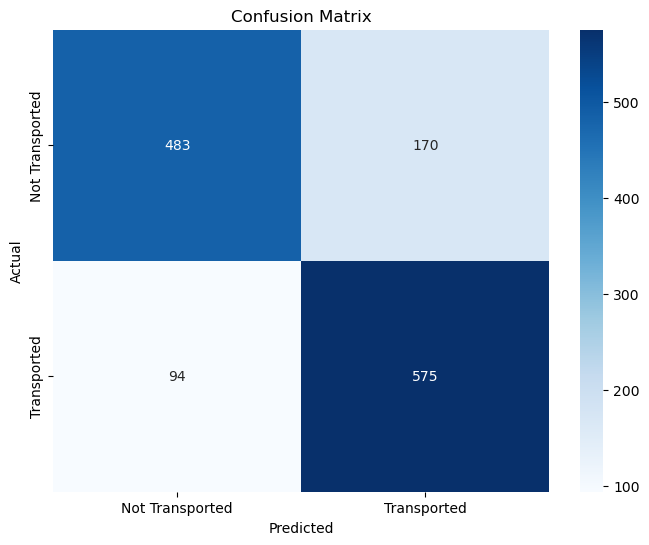


Classification Report:
                  precision    recall  f1-score   support

Not Transported       0.84      0.74      0.79       653
    Transported       0.77      0.86      0.81       669

       accuracy                           0.80      1322
      macro avg       0.80      0.80      0.80      1322
   weighted avg       0.80      0.80      0.80      1322



In [54]:
y_pred = best_rf.predict(X_test_selected)
y_pred_proba = best_rf.predict_proba(X_test_selected)[:, 1]  # Probabilities for ROC-AUC

accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Transported", "Transported"],
            yticklabels=["Not Transported", "Transported"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

class_report = classification_report(y_test, y_pred, target_names=["Not Transported", "Transported"])
print("\nClassification Report:\n", class_report)

## Grid Search

- Define hyperparameters to fine tune.

In [56]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400],      
    'max_depth': [10, 20, 30, None],           
    'min_samples_split': [2, 5, 10],           
    'min_samples_leaf': [1, 2, 4],             
    'bootstrap': [True, False]                
}

In [57]:
grid_search = GridSearchCV(estimator=rf, 
                           param_grid=param_grid, 
                           cv=5,                  
                           scoring='accuracy',     
                           n_jobs=-1,           
                           verbose=2)

In [58]:
grid_search.fit(X_train_selected, y_train)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   4.9s
[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   3.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.0s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estim

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [10, 20, 30, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300, 400]},
             scoring='accuracy', verbose=2)

In [59]:
print("Best Hyperparameters from Grid Search:", grid_search.best_params_)


Best Hyperparameters from Grid Search: {'bootstrap': True, 'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}


In [60]:
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test_selected)

print("Test Accuracy of Best Model:", accuracy_score(y_test, y_pred))

Test Accuracy of Best Model: 0.7950075642965204


- Evaluate your model

In [62]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.7950075642965204


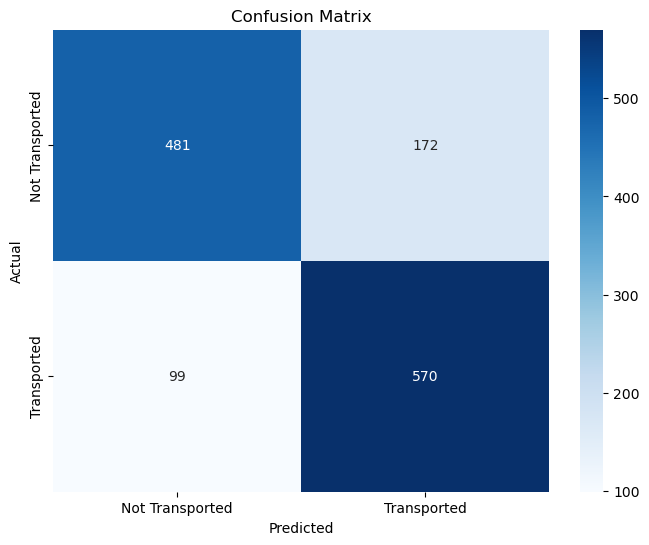

In [63]:
# 2. Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["Not Transported", "Transported"], 
            yticklabels=["Not Transported", "Transported"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [64]:
# 3. Classification Report
class_report = classification_report(y_test, y_pred, target_names=["Not Transported", "Transported"])
print("\nClassification Report:\n", class_report)



Classification Report:
                  precision    recall  f1-score   support

Not Transported       0.83      0.74      0.78       653
    Transported       0.77      0.85      0.81       669

       accuracy                           0.80      1322
      macro avg       0.80      0.79      0.79      1322
   weighted avg       0.80      0.80      0.79      1322

